## import os, sys
sys.path.append("../../common/")
from python_tools import *

In [2]:
%matplotlib notebook

In [3]:
# some useful functions
# 
# you may need to comment out the 'numba' bits if your system can't install numba (like the gpvms...)
#

@numba.jit
def costheta_numba(p1x,p1y,p1z,p1mag,
                   p2x,p2y,p2z,p2mag):
    return np.clip(np.where((p1mag>0.0)&(p2mag>0.0),
                            (p1x*p2x+p1y*p2y+p1z*p2z)/p1mag/p2mag,
                            np.nan),
                   -1.0,1.0)

def eval_costheta(df,suffix1="",suffix2=""):
    return costheta_numba(df.loc[:,"px"+suffix1].values,df.loc[:,"py"+suffix1].values,df.loc[:,"pz"+suffix1].values,df.loc[:,"p"+suffix1].values,
                          df.loc[:,"px"+suffix2].values,df.loc[:,"py"+suffix2].values,df.loc[:,"pz"+suffix2].values,df.loc[:,"p"+suffix2].values)

    
@numba.jit(nopython=True)
def q3_numba(p1x,p1y,p1z,p2x,p2y,p2z):
    return np.sqrt((p1x-p2x)**2+(p1y-p2y)**2+(p1z-p2z)**2)

def eval_q3(df,suffix1="",suffix2="_mu"):
    return q3_numba(df.loc[:,"px"+suffix1].values,df.loc[:,"py"+suffix1].values,df.loc[:,"pz"+suffix1].values,
                    df.loc[:,"px"+suffix2].values,df.loc[:,"py"+suffix2].values,df.loc[:,"pz"+suffix2].values)

In [4]:
root_filenames = glob.glob("/Users/wketchum/Data/MicroBooNE/FakeData2020/Set2/Run3/*/*.root")

In [5]:
#Read from files (ROOT or HDF5)

t_df = []
p_df = []
pot_df = []

file_count = 0
event_count = 0
print("Processing %d files" % len(root_filenames))

for root_filename in root_filenames:
    
    try:
        p_df.append(uproot.open(root_filename)['mcana/particle_tree'].pandas.df())
        t_df.append(uproot.open(root_filename)['mcana/mctruth_tree'].pandas.df())
        pot_df.append(uproot.open(root_filename)['potana/pot_tree'].pandas.df())
    except:
        print("File %s, trees not found."%root_filename)
    
    event_count += len(t_df[-1])
    file_count += 1
    if file_count%500==0:
        print("\tProcessed %d files. %d events processed." % (file_count,event_count))

p_df = pd.concat(p_df)
t_df = pd.concat(t_df)
pot_df = pd.concat(pot_df)

p_df.set_index(["run","subrun","event","truth_index","p_index"],inplace=True)
t_df.set_index(["run","subrun","event","truth_index"],inplace=True)
pot_df.set_index(["run","subrun"],inplace=True)
        
print("Have dataframe objects. Total events is %d." % len(t_df))

Processing 19513 files
	Processed 500 files. 8961 events processed.
	Processed 1000 files. 18131 events processed.
	Processed 1500 files. 27069 events processed.
File /Users/wketchum/Data/MicroBooNE/FakeData2020/Set2/Run3/32044093_1706/sampler_hist_1706.root, trees not found.
	Processed 2000 files. 36214 events processed.
	Processed 2500 files. 45385 events processed.
	Processed 3000 files. 54525 events processed.
	Processed 3500 files. 63836 events processed.
File /Users/wketchum/Data/MicroBooNE/FakeData2020/Set2/Run3/32044121_1183/sampler_hist_1183.root, trees not found.
	Processed 4000 files. 73192 events processed.
	Processed 4500 files. 82578 events processed.
	Processed 5000 files. 91642 events processed.
	Processed 5500 files. 100922 events processed.
	Processed 6000 files. 110031 events processed.
	Processed 6500 files. 119490 events processed.
	Processed 7000 files. 128757 events processed.
	Processed 7500 files. 137751 events processed.
	Processed 8000 files. 146855 events pr

In [6]:
# calculate integrated POT for all the events we have

TOTAL_POT = pot_df["totpot"].sum()
TOTAL_EVENTS = len(t_df)
print("\n\n")
print("Total events of %d in POT of %E. Events per 1e20 POT is %f" % (TOTAL_EVENTS,
                                                                      TOTAL_POT,
                                                                      TOTAL_EVENTS/(TOTAL_POT/1e20)))
print("\n\n")




Total events of 357262 in POT of 3.454393E+20. Events per 1e20 POT is 103422.517476





In [7]:
df_n = pd.DataFrame()
df_n["is_mu"] = ((p_df["status"]==1)&(p_df["pdgcode"]==13)).replace(False,np.nan)
df_n["is_p_30MeV"] = ((p_df["status"]==1)&(p_df["pdgcode"]==2212)&((p_df["e"]-p_df["mass"])>0.03)).replace(False,np.nan)
df_n["is_pi"] = ((p_df["status"]==1)&((p_df["pdgcode"]==211)^(p_df["pdgcode"]==-211)^(p_df["pdgcode"]==111))).replace(False,np.nan)
df_n = df_n.groupby(["run","subrun","event","truth_index"]).agg("sum").rename(columns={"is_mu":"n_mu","is_p_30MeV":"n_p_30MeV","is_pi":"n_pi"})

In [8]:
p_df_mu = p_df.query("status==1 and pdgcode==13").groupby(["run","subrun","event","truth_index"]).first()
p_df_nu = p_df.query("status==0 and pdgcode==14").groupby(["run","subrun","event","truth_index"]).first()

In [9]:
df_ev_t = t_df.copy()
df_ev_t = df_ev_t.merge(p_df_nu,how="left",on=["run","subrun","event","truth_index"],suffixes=["","_nu"])
df_ev_t = df_ev_t.merge(p_df_mu,how="left",on=["run","subrun","event","truth_index"],suffixes=["","_mu"])
df_ev_t = df_ev_t.merge(df_n,how="left",on=["run","subrun","event","truth_index"])

In [10]:
df_ev_t

n_particles  origin  mode  \
run      subrun event truth_index                              
32044093 5963   1     0                     12       1     1   
                2     0                     11       1     0   
                3     0                     12       1     1   
                4     0                     14       1     0   
                5     0                     12       1     1   
...                                        ...     ...   ...   
         9983   6     0                      8       1     0   
                7     0                     32       1     0   
                8     0                     12       1    10   
                9     0                     18       1    10   
                10    0                     13       1     0   

                                   interaction_type  ccnc      target  \
run      subrun event truth_index                                       
32044093 5963   1     0                        1007     1  1000180400   
                2     0                        1002     1  1000180400   
                3     0                        1003     0  1000180400   
                4     0                        1001     0  1000180400   
                5     0                        1003     0  1000180400   
...                                             ...   ...         ...   
         9983   6     0                        1001     0  1000180400   
                7     0                        1002     1  1000180400   
                8     0                        1000     0  1000180400   
                9     0                        1000     0  1000180400   
                10    0                        1001     0  1000180400   

                                     hit_nucl  hit_quark  hadronic_mass  \
run      subrun event truth_index                                         
32044093 5963   1     0                  2212          0       1.254441   
                2     0                  2112          0       1.050697   
                3     0                  2212          0       1.397657   
                4     0                  2112          0       0.933446   
                5     0                  2212          0       1.297618   
...                                       ...        ...            ...   
         9983   6     0                  2112          0       1.005090   
                7     0                  2212          0       1.059362   
                8     0            2000000200          0       0.949174   
                9     0            2000000201          0       1.239038   
                10    0                  2112          0       1.014163   

                                   interaction_x  ...     pt_mu      e_mu  \
run      subrun event truth_index                 ...                       
32044093 5963   1     0                 0.012864  ...       NaN       NaN   
                2     0                 0.758080  ...       NaN       NaN   
                3     0                 0.236101  ...  0.288972  0.386180   
                4     0                 1.014912  ...  0.490337  0.514387   
                5     0                 0.330562  ...  0.101340  0.168629   
...                                          ...  ...       ...       ...   
         9983   6     0                 0.652943  ...  0.202885  0.235770   
                7     0                 0.543713  ...       NaN       NaN   
                8     0                 0.964324  ...  0.523672  0.643029   
                9     0                 0.070226  ...  0.133959  0.377712   
                10    0                 0.660816  ...  0.384152  0.485892   

                                    mass_mu  end_px_mu  end_py_mu  end_pz_mu  \
run      subrun event truth_index                                              
32044093 5963   1     0                 NaN        NaN        NaN        NaN   
                2     0           

In [11]:
max_x = 250.
min_x = 5.
max_y = 100.
min_y = -100.
max_z = 1000.
min_z = 10.

fid_vol = (max_x-min_x)*(max_y-min_y)*(max_z-min_z)
print("Active volume: %f cm^3" % fid_vol)

ar_density=1.3836
ar_mmol = 39.95
av_k=6.02214e23
n_nucl=40

target_nucl=fid_vol*ar_density/ar_mmol*av_k*n_nucl
print("Target Nucleons: %.3e cm^3" % target_nucl)

Active volume: 48510000.000000 cm^3
Target Nucleons: 4.047e+31 cm^3


In [12]:
flux_per_pot = 7.379e-10
flux_tot = TOTAL_POT*flux_per_pot

print("Total Flux: %.3e cm^-2"%flux_tot)

Total Flux: 2.549e+11 cm^-2


In [13]:
query_mucc = ("n_mu==1 and ccnc==0 and start_x_mu>%f and start_x_mu<%f and start_y_mu>%f and start_y_mu<%f and start_z_mu>%f and start_z_mu<%f"%(min_x,max_x,min_y,max_y,min_z,max_z))
df_mucc = df_ev_t.query(query_mucc).copy()
EVENTS_FID=len(df_mucc)
print("total events = %d"%EVENTS_FID)

total events = 94313


In [14]:
total_xsec = EVENTS_FID/(flux_tot*target_nucl)
print(total_xsec)

9.142531089541006e-39


In [15]:
df_mucc["costheta_mu"] = eval_costheta(df=df_mucc,suffix1="",suffix2="_mu")
df_mucc["q0"] = df_mucc["e"] - df_mucc["e_mu"]
df_mucc["q3"] = eval_q3(df=df_mucc,suffix1="",suffix2="_mu")

<ipython-input-3-4cb27d444f36>:6: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "costheta_numba" failed type inference due to: Use of unsupported NumPy function 'numpy.clip' or unsupported use of the function.

File "<ipython-input-3-4cb27d444f36>", line 9:
def costheta_numba(p1x,p1y,p1z,p1mag,
    <source elided>
                   p2x,p2y,p2z,p2mag):
    return np.clip(np.where((p1mag>0.0)&(p2mag>0.0),
    ^

[1] During: typing of get attribute at <ipython-input-3-4cb27d444f36> (9)

File "<ipython-input-3-4cb27d444f36>", line 9:
def costheta_numba(p1x,p1y,p1z,p1mag,
    <source elided>
                   p2x,p2y,p2z,p2mag):
    return np.clip(np.where((p1mag>0.0)&(p2mag>0.0),
    ^

  @numba.jit
/Library/Python/3.7/site-packages/numba/core/object_mode_passes.py:178: NumbaWarning: Function "costheta_numba" was compiled in object mode without forceobj=True.

File "<ipython-input-3-4cb27d444f36>", line 7:
@numba.jit
def costheta_numb

In [16]:
df_mucc

n_particles  origin  mode  \
run      subrun event truth_index                              
32044093 5963   3     0                     12       1     1   
                5     0                     12       1     1   
                7     0                     15       1     1   
                20    0                     12       1    10   
32044041 4696   1     0                      9       1     0   
...                                        ...     ...   ...   
32044093 9983   2     0                      9       1     0   
                5     0                      8       1     0   
                6     0                      8       1     0   
                8     0                     12       1    10   
                10    0                     13       1     0   

                                   interaction_type  ccnc      target  \
run      subrun event truth_index                                       
32044093 5963   3     0                        1003     0  1000180400   
                5     0                        1003     0  1000180400   
                7     0                        1003     0  1000180400   
                20    0                        1000     0  1000180400   
32044041 4696   1     0                        1001     0  1000180400   
...                                             ...   ...         ...   
32044093 9983   2     0                        1001     0  1000180400   
                5     0                        1001     0  1000180400   
                6     0                        1001     0  1000180400   
                8     0                        1000     0  1000180400   
                10    0                        1001     0  1000180400   

                                     hit_nucl  hit_quark  hadronic_mass  \
run      subrun event truth_index                                         
32044093 5963   3     0                  2212          0       1.397657   
                5     0                  2212          0       1.297618   
                7     0                  2212          0       1.470114   
                20    0            2000000201          0       1.299231   
32044041 4696   1     0                  2112          0       0.906341   
...                                       ...        ...            ...   
32044093 9983   2     0                  2112          0       1.102137   
                5     0                  2112          0       1.024969   
                6     0                  2112          0       1.005090   
                8     0            2000000200          0       0.949174   
                10    0                  2112          0       1.014163   

                                   interaction_x  ...  end_px_mu  end_py_mu  \
run      subrun event truth_index                 ...                         
32044093 5963   3     0                 0.236101  ...   0.268631  -0.106499   
                5     0                 0.330562  ...  -0.009646  -0.100879   
                7     0                 0.292676  ...  -0.025663   0.312165   
                20    0                 0.034050  ...   0.013344  -0.124551   
32044041 4696   1     0                 1.060150  ...   0.149750  -0.440916   
...                                          ...  ...        ...        ...   
32044093 9983   2     0                 0.430368  ...   0.107251   0.028731   
                5     0                 0.370398  ...  -0.104858  -0.234826   
                6     0                 0.652943  ...   0.182219   0.089210   
                8     0                 0.964324  ...  -0.469348   0.232259   
                10    0                 0.660816  ...   0.013996   0.383897   

                                   end_pz_mu  end_e_mu  n_mu  n_p_30MeV  n_pi  \
run      subrun event truth_index                                               
32044093 5963   3     0             0.233380  0.386180   1.0        2.0   1.0   
     

In [209]:
genie_all_err_theta = np.load("CCInclusive_XSec_Set2_NPY/genie_all_err_arr_theta.npy")
genie_all_err_p = np.load("CCInclusive_XSec_Set2_NPY/genie_all_err_arr.npy")
genie_oth_err_theta = np.load("CCInclusive_XSec_Set2_NPY/genie_other_arr_theta.npy")
genie_oth_err_p = np.load("CCInclusive_XSec_Set2_NPY/genie_other_arr.npy")

migr_matrix_p = np.load("CCInclusive_XSec_Set2_NPY/migration_matrix_momentum.npy")
migr_matrix_theta = np.load("CCInclusive_XSec_Set2_NPY/migration_matrix_theta.npy")

data_p = np.load("CCInclusive_XSec_Set2_NPY/data_points_momentum.npy")
data_theta = np.load("CCInclusive_XSec_Set2_NPY/data_points_theta.npy")

bkg_p = np.load("CCInclusive_XSec_Set2_NPY/mc_bkg_points_momentum.npy")
bkg_theta = np.load("CCInclusive_XSec_Set2_NPY/mc_bkg_points_theta.npy")

eff_reco_p = np.load("CCInclusive_XSec_Set2_NPY/eff_tilde_momentum.npy")
eff_reco_theta = np.load("CCInclusive_XSec_Set2_NPY/eff_tilde_theta.npy")
eff_true_theta = np.load("CCInclusive_XSec_Set2_NPY/true_efficiency_theta.npy")

stat_err_theta = np.sqrt(data_theta)
bins_theta = np.load("CCInclusive_XSec_Set2_NPY/theta_bins.npy")
total_err_theta = np.load("CCInclusive_XSec_Set2_NPY/genie_all_err_arr_theta.npy")

target_nucl_fd = 4.10331109202e+31
flux_fd = 3.54124623456e+20*7.3789785277e-10



In [210]:
print(genie_all_err_theta)
print(stat_err_theta)
print(genie_oth_err_theta)
print(migr_matrix_theta)
print(data_theta)
print(bkg_theta)
print(data_theta-bkg_theta)

print(eff_reco_theta)
print(eff_true_theta)

print(bins_theta)


[0.01024703 0.00676064 0.01085275 0.01274773 0.0156214  0.01704674
 0.02123047 0.02712756 0.03388777]
[ 56.5862174   58.33523806  62.72160712  68.65129278  80.48602363
  92.59589624  99.18669266 101.0099005  106.40018797]
[0.00215465 0.00682779 0.0089534  0.00977813 0.01081549 0.01054868
 0.00690716 0.00967335 0.02082992]
[[7.39316998e-01 3.10833293e-02 2.35520341e-03 3.66189018e-03
  6.84163658e-03 5.57152908e-03 4.32236111e-03 4.27822141e-03
  6.62817292e-03]
 [3.15482089e-02 8.29478852e-01 7.00790887e-02 1.20011870e-02
  5.61411542e-03 1.62233830e-03 5.26732221e-04 1.76848251e-04
  5.61523891e-04]
 [2.60298083e-03 8.02299765e-02 8.39261204e-01 6.73953350e-02
  3.86149350e-03 1.38004230e-03 1.59724623e-03 6.32180614e-04
  6.28063196e-04]
 [1.31293713e-02 2.96350586e-02 8.16750022e-02 8.03114537e-01
  7.08610960e-02 3.84408285e-03 2.45867804e-03 1.56082890e-03
  1.10999742e-03]
 [3.61811691e-02 1.96884428e-02 3.29113501e-03 1.06988947e-01
  8.03146935e-01 6.93443535e-02 5.27126777e-03

<IPython.core.display.Javascript object>


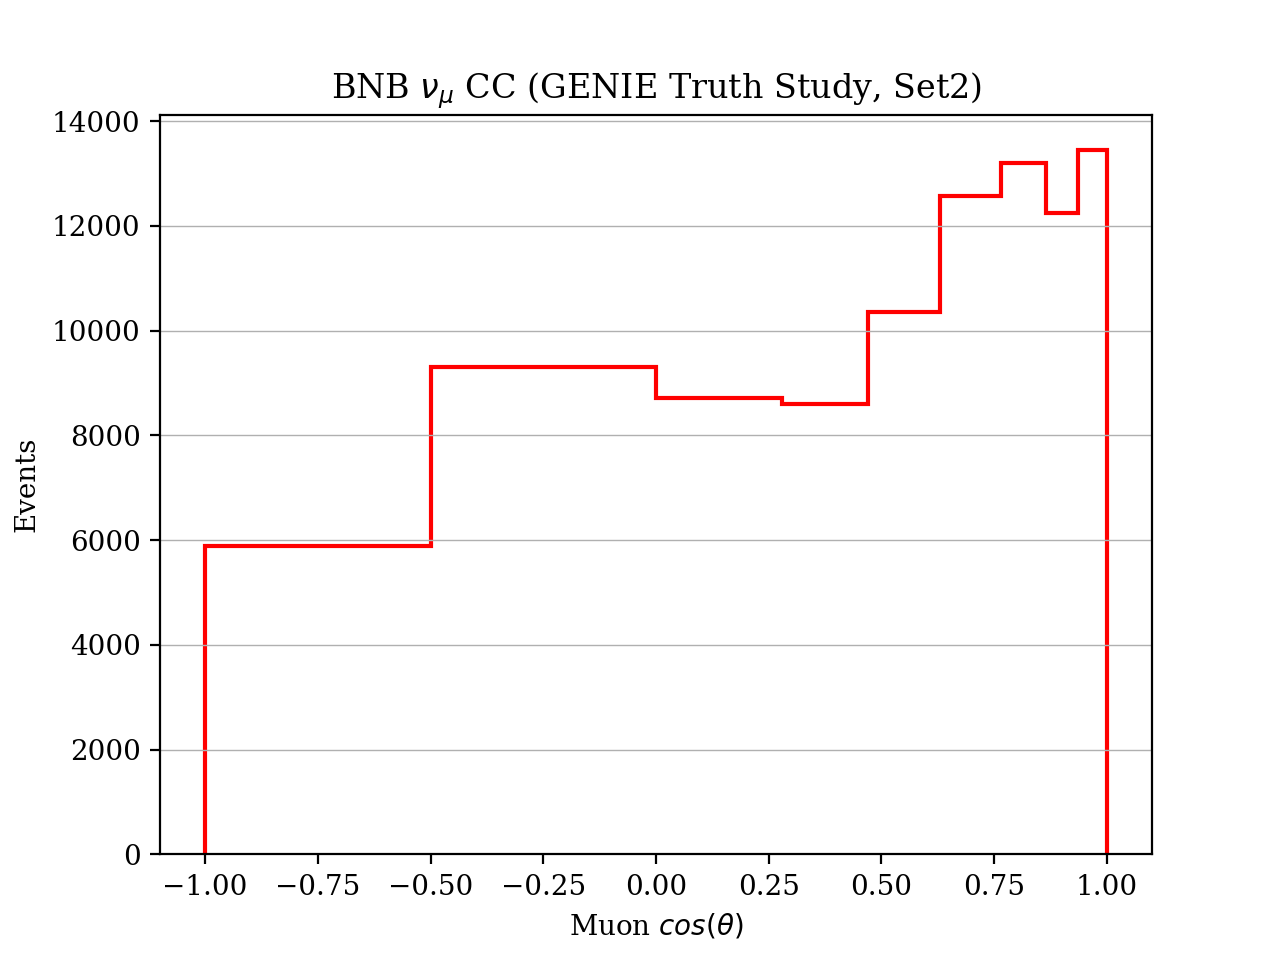

[ 5891.  9296.  8704.  8601. 10361. 12576. 13205. 12239. 13440.] [-1.    -0.5    0.     0.28   0.47   0.63   0.765  0.865  0.935  1.   ]


In [199]:
#bins_theta = [ -1.00, -0.50, 0.00, 0.28, 0.47, 0.63, 0.765, 0.865, 0.935, 1.00 ]

fig,ax = plt.subplots()

plt.grid(axis='y', linewidth=0.5)
evs_cth,ar_cth,patches = plt.hist(df_mucc["costheta_mu"], color='red', label='$\mu$', bins=bins_theta,**pltops_hist)
print(evs_cth,ar_cth)
#plt.legend(loc=2)
plt.title("BNB $\\nu_\mu$ CC (GENIE Truth Study, Set2)")
plt.xlabel("Muon $cos(\\theta)$")
plt.ylabel("Events")
plt.show()
#plt.savefig("plots/genie_1mu1p_costheta.pdf")

94313.0
94313.0


<IPython.core.display.Javascript object>


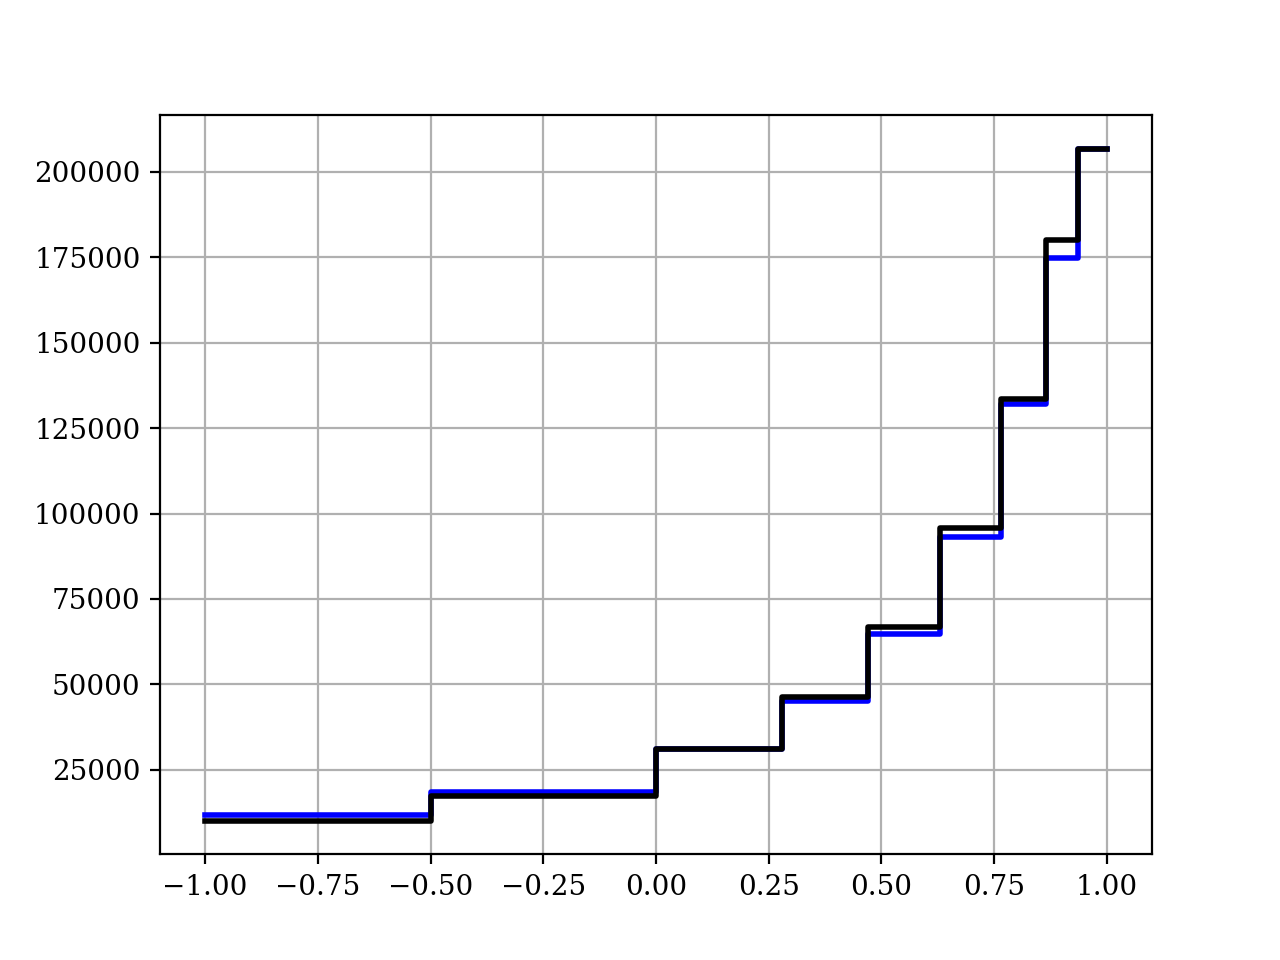

In [190]:
evs_cth_bn = np.array([ evs_cth[i]/(ar_cth[i+1]-ar_cth[i]) for i in range(len(evs_cth)) ])
evs_cth_bn_plt = np.append(evs_cth_bn,evs_cth_bn[-1])

evs_cth_sm = np.dot(migr_matrix_theta,evs_cth)
evs_cth_sm_bn = np.array([ evs_cth_sm[i]/(ar_cth[i+1]-ar_cth[i]) for i in range(len(evs_cth_sm)) ])
evs_cth_sm_bn_plt = np.append(evs_cth_sm_bn,evs_cth_sm_bn[-1])

print(np.sum(evs_cth))
print(np.sum(evs_cth_sm))

fig,ax = plt.subplots()
plt.plot(ar_cth,evs_cth_bn_plt,color='blue',linewidth=2.0,ds="steps-post",label="truth")
plt.plot(ar_cth,evs_cth_sm_bn_plt,color='black',linewidth=2.0,ds="steps-post",label="smeared")
plt.grid()
plt.show()

In [218]:
print(evs_cth,"\n")
print(evs_cth*eff_true_theta,"\n")
print(np.dot(migr_matrix_theta,evs_cth*eff_true_theta),"\n")

print(np.dot(migr_matrix_theta,evs_cth),"\n")
print(np.dot(migr_matrix_theta,evs_cth)*eff_reco_theta,"\n")

[ 5891.  9296.  8704.  8601. 10361. 12576. 13205. 12239. 13440.] 

[1597.19344655 2470.28558445 2772.02670288 3605.21240661 5120.58921674
 7046.56282997 8508.36617023 8575.52279216 9668.32489014] 

[1489.18842894 2388.5728559  2826.35861596 3650.955192   5195.54426495
 7178.20507474 8440.52491322 8671.06613351 9523.6685605 ] 

[ 5035.73699374  8705.11370434  8740.38323045  8820.34317949
 10676.22847437 12943.71486048 13347.59633247 12607.20492614
 13436.67829853] 

[1489.09709411 2387.97182892 2825.70828748 3650.17662388 5195.3565025
 7178.01827133 8441.63846192 8675.15940185 9527.91822127] 



[ 5891.  9296.  8704.  8601. 10361. 12576. 13205. 12239. 13440. 13440.]
[ 5035.73699374  8705.11370434  8740.38323045  8820.34317949
 10676.22847437 12943.71486048 13347.59633247 12607.20492614
 13436.67829853 13436.67829853]
[1489.09709411 2387.97182892 2825.70828748 3650.17662388 5195.3565025
 7178.01827133 8441.63846192 8675.15940185 9527.91822127]


<IPython.core.display.Javascript object>


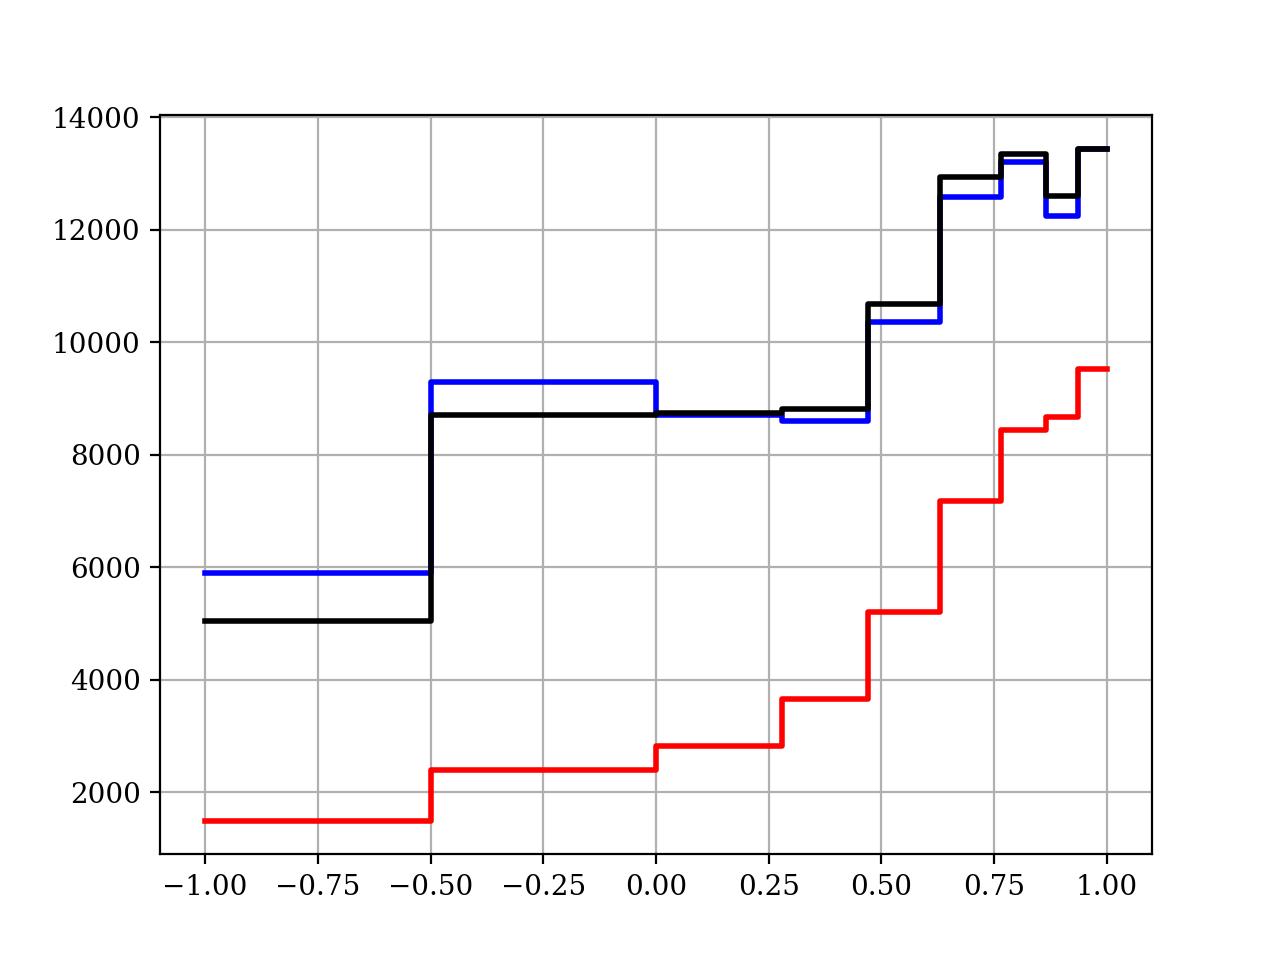

In [206]:
evs_cth_sm_eff = evs_cth_sm*eff_reco_theta

evs_cth_sm_plt = np.append(evs_cth_sm,evs_cth_sm[-1])
evs_cth_plt = np.append(evs_cth,evs_cth[-1])
evs_cth_sm_eff_plt = np.append(evs_cth_sm_eff,evs_cth_sm_eff[-1])

print(evs_cth_plt)
print(evs_cth_sm_plt)
print(evs_cth_sm_eff)

fig,ax = plt.subplots()
plt.plot(ar_cth,evs_cth_plt,color='blue',linewidth=2.0,ds="steps-post",label="truth")
plt.plot(ar_cth,evs_cth_sm_plt,color='black',linewidth=2.0,ds="steps-post",label="smeared")
plt.plot(ar_cth,evs_cth_sm_eff_plt,color='red',linewidth=2.0,ds="steps-post",label="efficiency applied")
plt.grid()
plt.show()

In [191]:
#print(evs_cth_sm)
#print(ar_cth)
dxsec_dcth_tr = np.array([ evs_cth[i]/(ar_cth[i+1]-ar_cth[i])/(flux_tot*target_nucl) for i in range(len(evs_cth))])
dxsec_dcth = np.array([ evs_cth_sm[i]/(ar_cth[i+1]-ar_cth[i])/(flux_tot*target_nucl) for i in range(len(evs_cth))])
dxsec_dcth_fd = np.array([ (data_theta[i]-bkg_theta[i])/(ar_cth[i+1]-ar_cth[i])/(flux_fd*target_nucl_fd*eff_reco_theta[i]) for i in range(len(data_theta))])
dxsec_dcth_staterr_fd = np.array([ (stat_err_theta[i])/(ar_cth[i+1]-ar_cth[i])/(flux_fd*target_nucl_fd*eff_reco_theta[i]) for i in range(len(stat_err_theta))])
print(dxsec_dcth_tr)
print(dxsec_dcth)
print(dxsec_dcth_fd)
xsec_tot_dcth_check=0
xsec_tot_dcth_tr_check=0
xsec_tot_dcth_fd_check=0
for i in range(len(dxsec_dcth)):
    xsec_tot_dcth_check += dxsec_dcth[i]*(ar_cth[i+1]-ar_cth[i])
    xsec_tot_dcth_tr_check += dxsec_dcth_tr[i]*(ar_cth[i+1]-ar_cth[i])
    xsec_tot_dcth_fd_check += dxsec_dcth_fd[i]*(ar_cth[i+1]-ar_cth[i])    
print(xsec_tot_dcth_check,xsec_tot_dcth_tr_check,xsec_tot_dcth_fd_check)
print(xsec_tot_dcth_fd_check/xsec_tot_dcth_check)
print(dxsec_dcth_fd*genie_all_err_theta)

dxsec_dcth_fd_err = np.array([ np.sqrt(1e-38*genie_all_err_theta[i]*1e-38*genie_all_err_theta[i]+dxsec_dcth_staterr_fd[i]*dxsec_dcth_staterr_fd[i]) for i in range(len(stat_err_theta))])
dxsec_dcth_fd_xsec_err = np.array([ np.sqrt(1e-38*genie_all_err_theta[i]*1e-38*genie_all_err_theta[i]) for i in range(len(stat_err_theta))])
ar_cth_mid = np.array([ (ar_cth[i+1]+ar_cth[i])*0.5 for i in range(len(ar_cth)-1) ])
ar_cth_err = np.array([ (ar_cth[i+1]-ar_cth[i])*0.5 for i in range(len(ar_cth)-1) ])
print(ar_cth_mid)
print(ar_cth_err)
print(dxsec_dcth_fd_err/dxsec_dcth_fd)
print(dxsec_dcth_fd_xsec_err/dxsec_dcth_fd)
print(dxsec_dcth_staterr_fd/dxsec_dcth_fd)


[1.14212570e-39 1.80227474e-39 3.01339274e-39 4.38823860e-39
 6.27735338e-39 9.03033053e-39 1.28006874e-38 1.69489493e-38
 2.00438340e-38]
[9.76310414e-40 1.68771585e-39 3.02598890e-39 4.50014770e-39
 6.46833885e-39 9.29437209e-39 1.29389177e-38 1.74588510e-38
 2.00388802e-38]
[1.17908824e-39 1.79284704e-39 3.24550465e-39 4.66044908e-39
 6.63810304e-39 9.37816208e-39 1.28879218e-38 1.76161827e-38
 2.00878151e-38]
9.142531089541005e-39 9.142531089541006e-39 9.43597558581661e-39
1.0320966364130064
[1.20821498e-41 1.21208009e-41 3.52226550e-41 5.94101342e-41
 1.03696452e-40 1.59867108e-40 2.73616582e-40 4.77884019e-40
 6.80731180e-40]
[-0.75   -0.25    0.14    0.375   0.55    0.6975  0.815   0.9     0.9675]
[0.25   0.25   0.14   0.095  0.08   0.0675 0.05   0.035  0.0325]
[0.09202792 0.04372033 0.03891834 0.03245722 0.02765378 0.02194761
 0.02000415 0.01898407 0.01998651]
[0.08690637 0.03770898 0.03343933 0.027353   0.02353293 0.01817706
 0.01647315 0.01539923 0.01686981]
[0.03027245 0.022

<IPython.core.display.Javascript object>


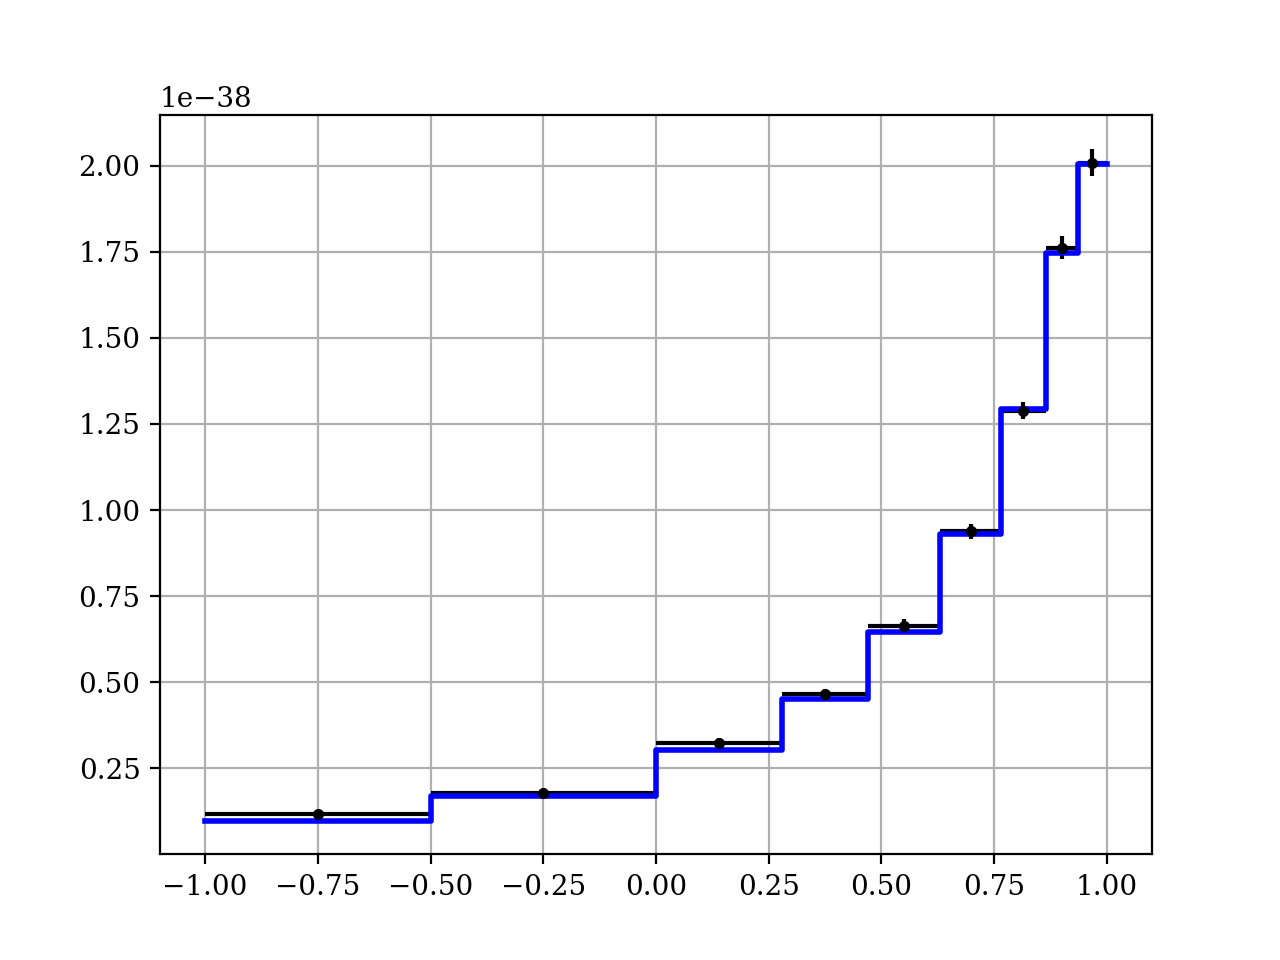

In [192]:
dxsec_dcth_plt = np.append(dxsec_dcth,dxsec_dcth[-1])
#dxsec_dcth_fd_plt=dxsec_dcth_fd.copy()
#dxsec_dcth_fd_plt.append(dxsec_dcth_fd[-1])

#ar_cth_mid = [ (ar_cth[i+1]+ar_cth[i])*0.5 for i in range(len(ar_cth)-1) ]

fig,ax = plt.subplots()
plt.plot(ar_cth,dxsec_dcth_plt,color='blue',linewidth=2.0,ds="steps-post",label="truth")
#plt.plot(ar_cth,dxsec_dcth_fd_plt,color='black',linewidth=2.0,ds="steps-post",label="fake data")
plt.errorbar(x=ar_cth_mid,y=dxsec_dcth_fd,xerr=ar_cth_err,yerr=dxsec_dcth_fd_err,fmt=".",color='black',label="fake data")
plt.grid()
#plt.legend()
#plt.title("LEE $\\nu_e$ signal model weights",fontsize=24)
#plt.xlabel("$E_\\nu$ (GeV)",fontsize=18)
#plt.ylabel("weight",fontsize=18)
plt.show()

<IPython.core.display.Javascript object>


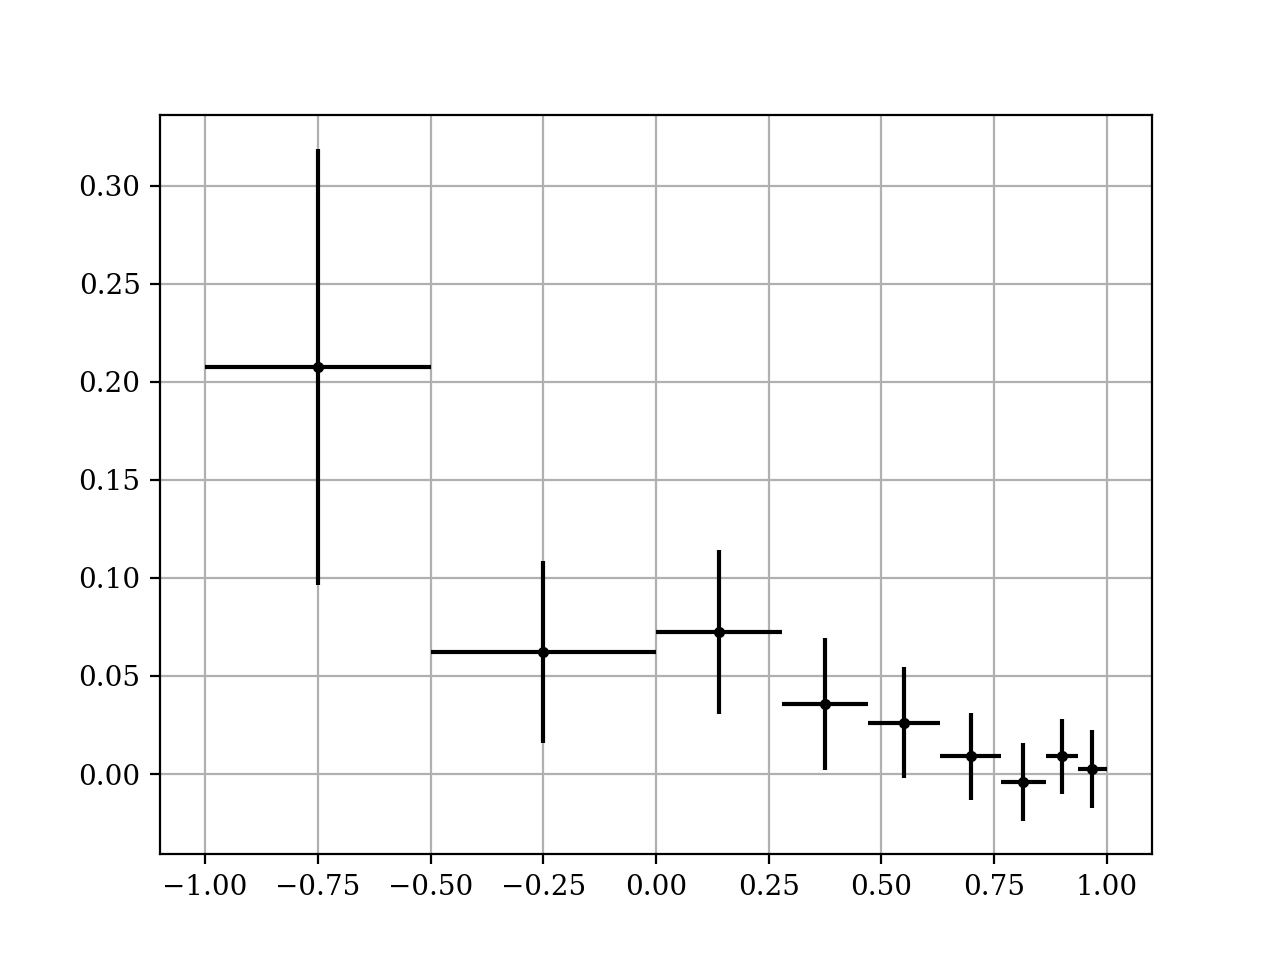

In [193]:
dxsec_dcth_diff = [ (dxsec_dcth_fd[i]/dxsec_dcth[i] - 1.0) for i in range(len(dxsec_dcth))]
dxsec_dcth_diff_err = [ (dxsec_dcth_fd_err[i]/dxsec_dcth[i]) for i in range(len(dxsec_dcth))]

fig,ax = plt.subplots()
plt.errorbar(x=ar_cth_mid,y=dxsec_dcth_diff,xerr=ar_cth_err,yerr=dxsec_dcth_diff_err,fmt=".",color='black',label="fake data")
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


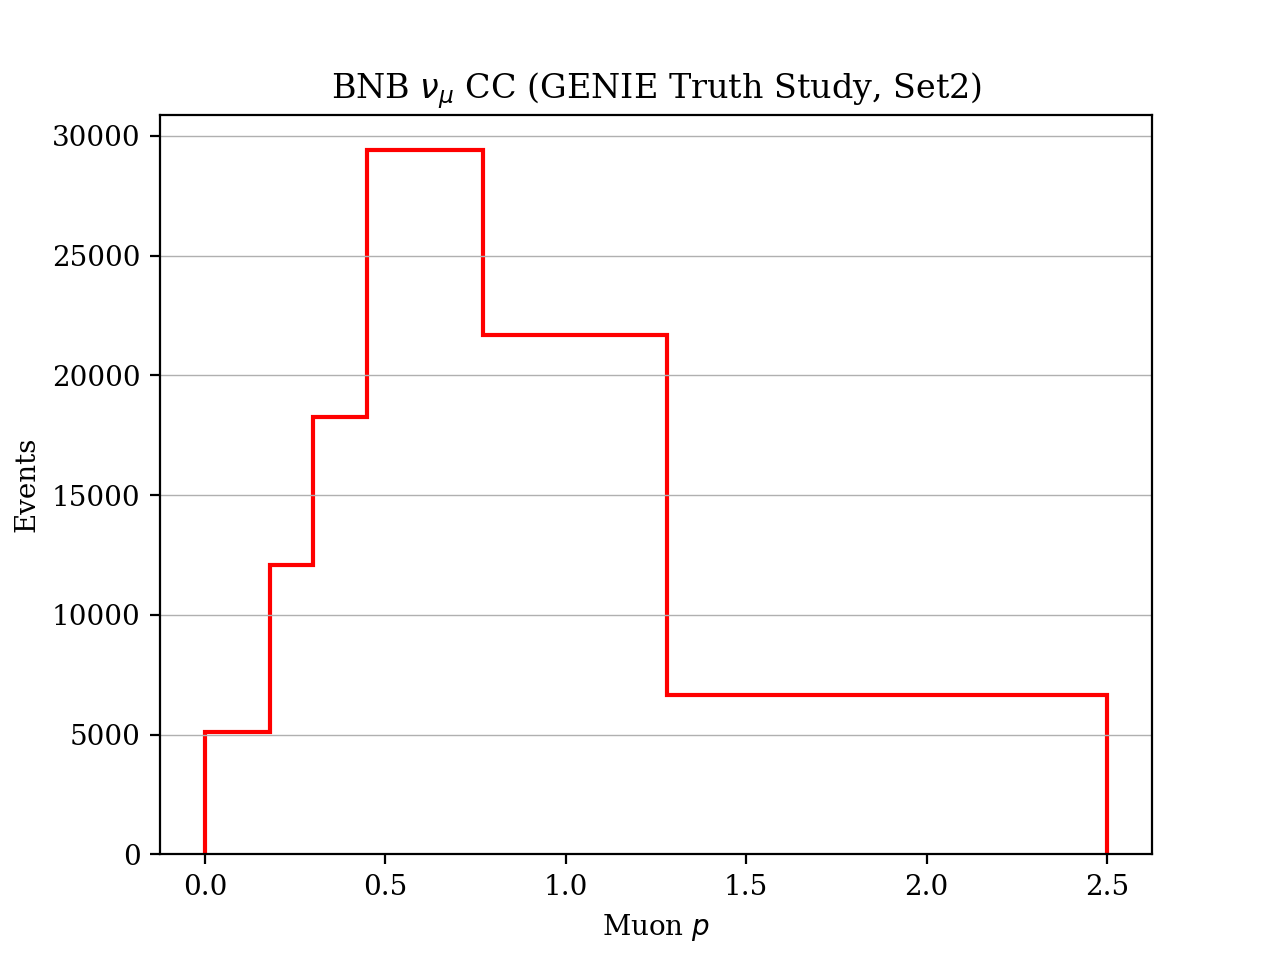

In [126]:
bins_p = [ 0.00, 0.18, 0.30, 0.45, 0.77, 1.28, 2.50 ]

fig,ax = plt.subplots()

plt.grid(axis='y', linewidth=0.5)
evs_p,ar_p,patches = plt.hist(df_mucc["p_mu"], color='red', label='$\mu$', bins=bins_p,**pltops_hist)
#plt.legend()
plt.title("BNB $\\nu_\mu$ CC (GENIE Truth Study, Set2)")
plt.xlabel("Muon $p$")
plt.ylabel("Events")
plt.show()
#plt.savefig("plots/genie_1mu1p_costheta.pdf")

In [127]:
print(evs_p)
print(ar_p)
dxsec_dp = [ evs_p[i]/(ar_p[i+1]-ar_p[i])/(flux_tot*target_nucl) for i in range(len(evs_p))]
print(dxsec_dp)
xsec_tot_dp_check=0
for i in range(len(dxsec_dp)):
    print(dxsec_dp[i]*(ar_p[i+1]-ar_p[i]))
    xsec_tot_dp_check += dxsec_dp[i]*(ar_p[i+1]-ar_p[i])
print(xsec_tot_dp_check)

[ 5128. 12080. 18261. 29392. 21702.  6645.]
[0.   0.18 0.3  0.45 0.77 1.28 2.5 ]
[2.7616611959448432e-39, 9.758444007511809e-39, 1.1801254703388948e-38, 8.903772338641983e-39, 4.125004905551642e-39, 5.279952808862988e-40]
4.970990152700718e-40
1.1710132809014171e-39
1.7701882055083425e-39
2.8492071483654346e-39
2.1037525018313372e-39
6.441542426812845e-40
9.035414394557888e-39


<IPython.core.display.Javascript object>


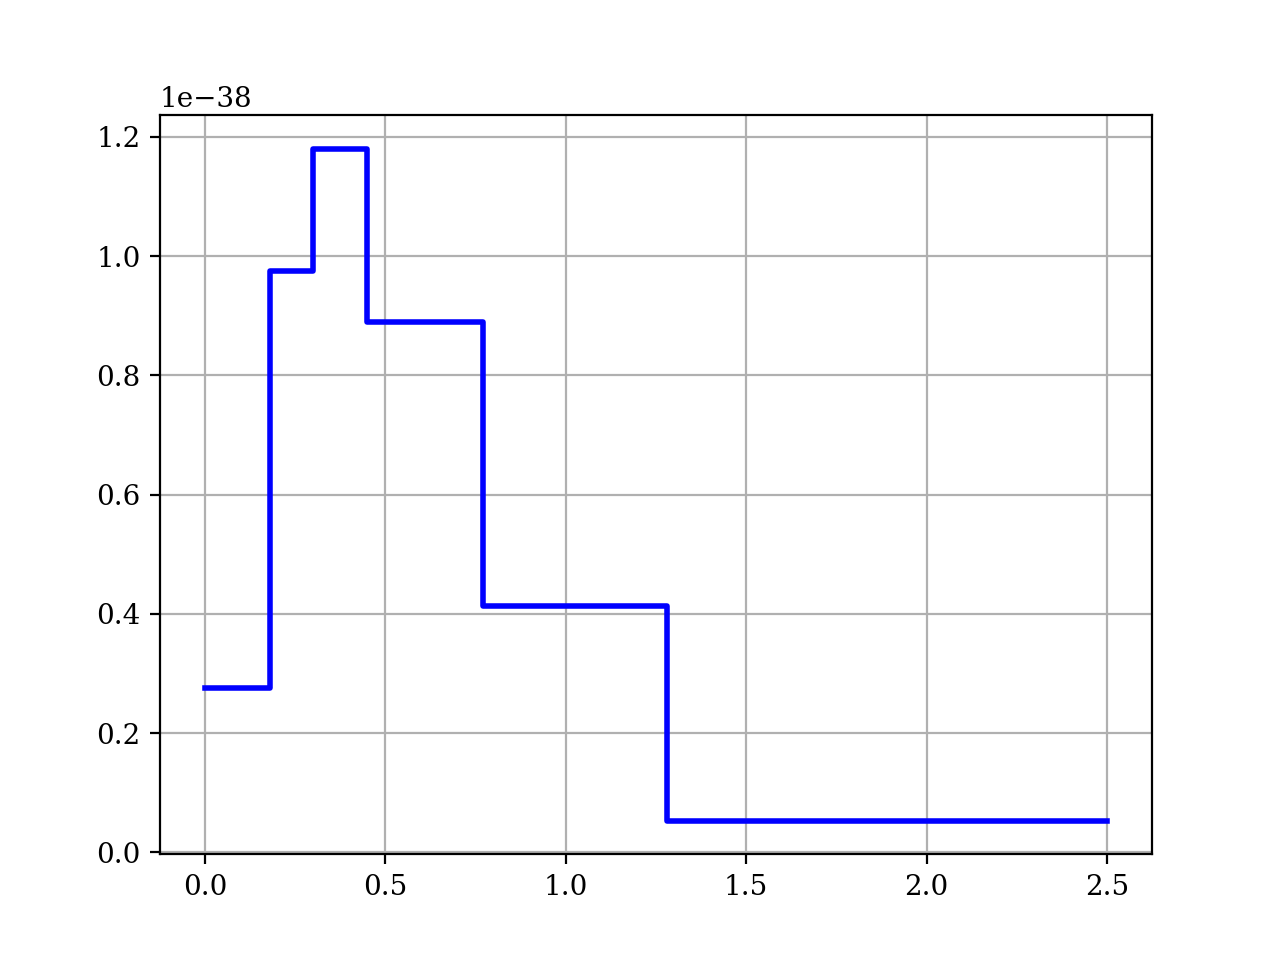

In [128]:
dxsec_dp_plt=dxsec_dp
dxsec_dp_plt.append(dxsec_dp[-1])

fig,ax = plt.subplots()
plt.plot(ar_p,dxsec_dp_plt,color='blue',linewidth=2.0,ds="steps-post")
plt.grid()
#plt.legend()
#plt.title("LEE $\\nu_e$ signal model weights",fontsize=24)
#plt.xlabel("$E_\\nu$ (GeV)",fontsize=18)
#plt.ylabel("weight",fontsize=18)
plt.show()

In [ ]:
bins_x = np.arange(-100,300,1)
bins_y = np.arange(-200,200,1)
bins_z = np.arange(-200,1500,1)

fig,axes = plt.subplots(3,1)

axes[0].grid(axis='y', linewidth=0.5)
axes[0].hist(df_mucc["start_x_mu"], color='red', label='$\mu$', bins=bins_x,**pltops_hist)
axes[1].grid(axis='y', linewidth=0.5)
axes[1].hist(df_mucc["start_y_mu"], color='red', label='$\mu$', bins=bins_y,**pltops_hist)
axes[2].grid(axis='y', linewidth=0.5)
axes[2].hist(df_mucc["start_z_mu"], color='red', label='$\mu$', bins=bins_z,**pltops_hist)
#plt.legend()
#plt.title("BNB $\\nu_\mu$ CC (GENIE Truth Study, Set2)")
#plt.xlabel("Muon $p$")
#plt.ylabel("Events")
plt.show()
#plt.savefig("plots/genie_1mu1p_costheta.pdf")